# Train Ordinary Torch Model 

If you have a torch model as an instance of `torch.nn.Module` it can be easily integrated into a training or inference pipeline.

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet50

sys.path.append("../..")

from batchflow import Pipeline, B, C, D, V, W
from batchflow.models.torch import TorchModel
from batchflow.opensets import Imagenette160
from batchflow.utils import plot_images_predictions

# Create dataset

Load [Imagenette](https://github.com/fastai/imagenette) dataset. It may take few minutes.

In [2]:
dataset = Imagenette160()

You can experiment with [MNIST](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html#mnist) and [CIFAR](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html#cifar100) datasets as well.   
Download and use them in the same manner.

# Define model config

We use `resnet50` model from `torchvision.models` zoo.   
In the config you must specify that the `body` of your model is `resnet50` module. Optionally you could add more laysers on top of the net by specifying `head`.

Let's illustrate this with example. `resnet50` model, like all classification networks from `torchvision.models` zoo, is customized for `Imagenet` dataset, i.e. have dense layer on top of it with 1000 neurons.   
Take a look at the last 5 layers of `resnet50`.

In [3]:
list(resnet50().modules())[-5:]

[Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=2048, out_features=1000, bias=True)]

But the `Imagenette` dataset is a subset of `Imagenet` and has only 10 classes.   
To customize the net for our dataset, we add `BatchNorm`, `Activation`, `Dense` layer with 10 neurons on top of the `resnet50` model via `head/layout` parameter.   

Note in this case you need to specify the shape of the tensor passing from `body` to `head` via `head/inputs`

In [4]:
config = {'inputs/images/shape': (3, 160, 160),
          'inputs/labels/classes': 10,
          'initial_block/inputs': 'images',
          'body': resnet50(),
          'head': dict(layout='af', inputs=(1, 1000), units=10),
          'loss': 'ce',
          'output/predicted': ['proba']
}

# Create train pipeline

In the pipeline we apply two preprocessing steps to the batch of images.   
First, we crop the images so the whole batch consists of the crops with the same size.   
Secondly, convert the batch of PIL images to the numpy array to make it compatible with torch models.

In [5]:
train_pipeline = (dataset.train.p
                    .init_variable('loss_history', default=[])
                    .init_model('dynamic', TorchModel, 'my_model', config)
                    .crop(shape=(160, 160), origin='center')
                    .to_array(channels='first', dtype='float32') 
                    .train_model('my_model', B.images, B.labels, fetches='loss',
                                 save_to=V('loss_history', mode='a'))
                 )

Training may take some time.

# Train the model

In [ ]:
train_pipeline.run(64, shuffle=True, n_iters=1000, drop_last=True, bar=True,
                   bar_desc=W(V('loss_history')[-1].format('Loss is: {:7.7}')))

Take a look at the loss function plot.

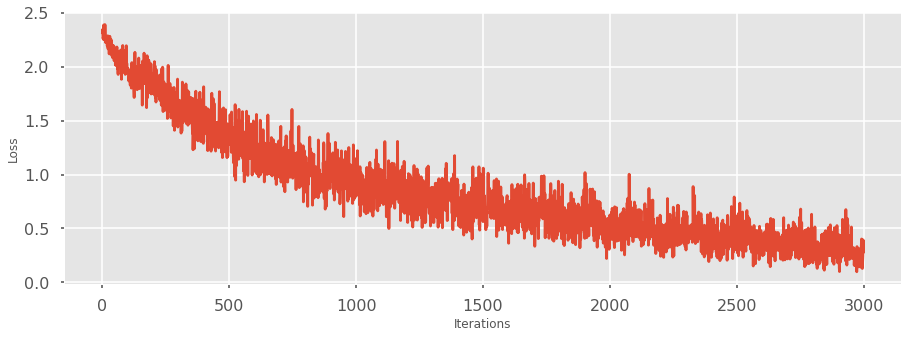

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(train_pipeline.v('loss_history'))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Training might be continued as the loss is not on plateu yet.

# Test the model 

In [6]:
test_pipeline = (dataset.test.p
                    .init_variable('predictions')
                    .init_variable('metrics', default=None)
                    .import_model('my_model', train_pipeline)
                    .crop(shape=(160,160), origin='center')
                    .to_array(channels='first', dtype='float32') # make it compatible with torch models
                    .predict_model('my_model', B.images,
                                   fetches='predicted_proba', save_to=V('predictions'))
                    .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                    fmt='proba', axis=-1, save_to=V('metrics', mode='a'))
                    .apply_transform_all(src='images', dst='images', 
                                     func=lambda x: np.transpose(x, (0, 2, 3, 1)).astype(int)) # make it compatible with plt.imshow()
                )

In [7]:
test_pipeline.run(50, shuffle=True, n_epochs=1, drop_last=False, bar=True)

100%|██████████| 10/10 [00:07<00:00,  2.64it/s]


In [8]:
metrics = test_pipeline.get_variable('metrics')

In [9]:
metrics.evaluate('accuracy')

0.8077837837837839

In [10]:
batch = test_pipeline.next_batch(10, shuffle=True)

Take a look at the predictions.

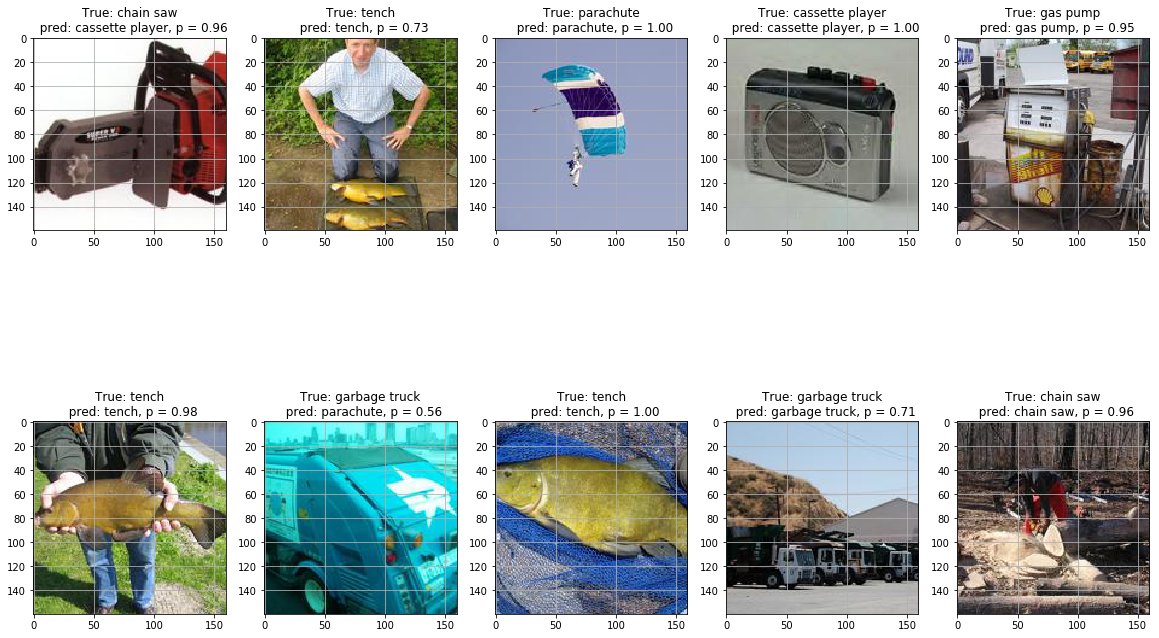

In [11]:
plot_images_predictions(batch.images, batch.labels, batch.pipeline.v('predictions'),
                        classes=dataset.name_classes, figsize=(20,20))